<a href="https://colab.research.google.com/github/Long2511/ai-project/blob/main/project_AI_Retrival_colpali_qrant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    print("[colab] Drive mounted at /content/drive")
except Exception as e:
    print("[note] Not in Colab or Drive mount failed:", e)

Mounted at /content/drive
[colab] Drive mounted at /content/drive


In [2]:
import sys, subprocess, os
def sh(cmd): print(cmd); subprocess.run(cmd, shell=True, check=True)

# CUDA 12.1-compatible torch for Colab
!python3 -m pip -q install --index-url https://download.pytorch.org/whl/cu121 "torch==2.5.1" "torchaudio==2.5.1" "torchvision==0.20.1"
# Core libs: ColPali, transformers, qdrant-client (multi-vector), OCR, PDF
!python3 -m pip -q install "transformers>=4.53.1,<4.54.0" colpali-engine==0.3.12 "qdrant-client>=1.7.3,<2" accelerate sentencepiece pdf2image pytesseract
# System deps for OCR/PDF
sh('apt-get -y update && apt-get -y install tesseract-ocr poppler-utils')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 117.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 134.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 109.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 136.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
SOURCE_DIR         = "/content/drive/MyDrive/Project-AI/PDF-Data"
MODEL_NAME         = "vidore/colpali-v1.2-hf"

# Outputs
PAGES_JSONL        = "/content/clinical_cases_index.jsonl"
CASES_JSONL        = "/content/clinical_cases_cases.jsonl"
STRUCT_JSONL       = "/content/clinical_cases_cases_structured.jsonl"
SFT_EXTRACT_JSONL  = "/content/clinical_cases_extract_sft.jsonl"
SFT_DX_JSONL       = "/content/clinical_cases_dx_sft.jsonl"

# Qdrant collections
COLLECTION_PAGES   = "tropical_cases_colpali_pages"
COLLECTION_CASES   = "tropical_cases_colpali_cases"
VECTOR_SIZE        = 128  # ColPali subvector dim
VECTOR_NAME = "default"

# Toggles
INDEX_PAGES        = True
INDEX_CASES        = True
ENABLE_OCR         = True
ENABLE_PDF         = True
BATCH              = 2      # embedding batch size
MAX_FILES          = None   # set small int to smoke-test

# Qdrant remote (REST-only)
QDRANT_HOST        = "165.22.56.15"
QDRANT_PORT        = 6333    # QRPcQDRANT_API_KEY     = os.getenv("QDRANT_API_KEY") or None
QDRANT_TIMEOUT     = 1200.0  # large to be safe
UPSERT_BATCH       = 12      # points per upsert() call; keep small for reliability
UPSERT_MAX_RETRIES = 6

In [10]:
import re, json, glob, hashlib, io, time
from typing import List, Dict, Any, Tuple
from PIL import Image
from tqdm import tqdm
import torch
from collections import defaultdict
from typing import Optional


from transformers import ColPaliForRetrieval, ColPaliProcessor
from qdrant_client import QdrantClient, models

try:
    import pytesseract
except Exception as e:
    print("[warn] OCR disabled:", e); ENABLE_OCR=False

try:
    from pdf2image import convert_from_path
except Exception as e:
    print("[warn] PDF→image disabled:", e); ENABLE_PDF=False

In [5]:
def load_colpali(device=None):
    device = device or ("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"[env] device={device}\n[env] loading ColPali…")

    model = ColPaliForRetrieval.from_pretrained(
        MODEL_NAME,
        torch_dtype=(torch.bfloat16 if torch.cuda.is_available() else torch.float32),
    ).eval()
    model.to(device)

    processor = ColPaliProcessor.from_pretrained(MODEL_NAME)
    print("[env] ColPali loaded.")
    return model, processor, device

@torch.no_grad()
def embed_images(model, processor, device, pil_images: List[Image.Image]):
    batch = processor(images=pil_images).to(device)
    emb = model(**batch).embeddings  # [B, N, 128] multivectors
    return [e.to("cpu").float().tolist() for e in emb]  # List[List[List[float]]]

@torch.no_grad()
def embed_queries(model, processor, device, queries: List[str]):
    batch = processor(text=queries).to(device)
    emb = model(**batch).embeddings
    return [e.to("cpu").float().tolist() for e in emb]

In [6]:
def connect_qdrant_rest():
    url = f"http://{QDRANT_HOST}:{QDRANT_PORT}"
    client = QdrantClient(
        url=url,
        api_key=None,
        timeout=QDRANT_TIMEOUT,
        prefer_grpc=False,  # <- HARD disable gRPC
    )
    # sanity call
    client.get_collections()
    print(f"[qdrant] connected (REST-only): {url}")
    return client

def ensure_collection(client: QdrantClient, name: str):
    try:
        exists = client.collection_exists(name)
    except Exception:
        # REST fallback path if needed
        try:
            client.http.collections_api.get_collection(name)
            exists = True
        except Exception:
            exists = False

    if not exists:
        print(f"[qdrant] creating collection: {name}")
        client.create_collection(
            collection_name=name,
            vectors_config={
                VECTOR_NAME: models.VectorParams(
                    size=VECTOR_SIZE,
                    distance=models.Distance.COSINE,
                    multivector_config=models.MultiVectorConfig(
                        comparator=models.MultiVectorComparator.MAX_SIM
                    ),
                )
            },
            on_disk_payload=True,
            hnsw_config=models.HnswConfigDiff(m=32, ef_construct=128),
            optimizers_config=models.OptimizersConfigDiff(default_segment_number=2),
        )
    else:
        print(f"[qdrant] collection exists: {name}")

# Deterministic 63-bit IDs (so re-runs are true updates)
def stable_point_id(key: str) -> int:
    h = hashlib.sha1(key.encode("utf-8")).hexdigest()
    return int(h[:15], 16) & ((1<<63)-1)

In [7]:
client = connect_qdrant_rest()
model, processor, device = load_colpali()



[qdrant] connected (REST-only): http://165.22.56.15:6333
[env] device=cuda:0
[env] loading ColPali…


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at vidore/colpali-v1.2-hf were not used when initializing ColPaliForRetrieval: ['vlm.language_model.model.embed_tokens.weight', 'vlm.language_model.model.layers.0.input_layernorm.weight', 'vlm.language_model.model.layers.0.mlp.down_proj.weight', 'vlm.language_model.model.layers.0.mlp.gate_proj.weight', 'vlm.language_model.model.layers.0.mlp.up_proj.weight', 'vlm.language_model.model.layers.0.post_attention_layernorm.weight', 'vlm.language_model.model.layers.0.self_attn.k_proj.weight', 'vlm.language_model.model.layers.0.self_attn.o_proj.weight', 'vlm.language_model.model.layers.0.self_attn.q_proj.weight', 'vlm.language_model.model.layers.0.self_attn.v_proj.weight', 'vlm.language_model.model.layers.1.input_layernorm.weight', 'vlm.language_model.model.layers.1.mlp.down_proj.weight', 'vlm.language_model.model.layers.1.mlp.gate_proj.weight', 'vlm.language_model.model.layers.1.mlp.up_proj.weight', 'vlm.language_model.model.layers.1.post_attention_layernor

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

[env] ColPali loaded.


# Retrival with cases-level

In [8]:
info = client.get_collection(COLLECTION_CASES)
print(info)  # xem phần vector params / tên


status=<CollectionStatus.GREEN: 'green'> optimizer_status=<OptimizersStatusOneOf.OK: 'ok'> vectors_count=None indexed_vectors_count=93 points_count=93 segments_count=2 config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=128, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=MultiVectorConfig(comparator=<MultiVectorComparator.MAX_SIM: 'max_sim'>)), shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=32, ef_construct=128, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=2, max_segment_size=None, memmap_threshold=None, indexing_threshold=10000, flush_interval_sec=5, max_optimization_threads=None), wal_config=WalConfig

###

In [11]:
def encode_query_colpali(q: str):

    subvecs = embed_queries(model, processor, device, [q])[0]

    return [ (sv.tolist() if hasattr(sv, "tolist") else list(sv)) for sv in subvecs ]



def search_cases_MAX(question: str, k: int = 5, filter_modality: Optional[str] = None):
    subvecs = encode_query_colpali(question)

    qfilter = None
    if filter_modality:
        qfilter = models.Filter(must=[
            models.FieldCondition(key="modality", match=models.MatchValue(value=filter_modality))
        ])

    agg = {}

    for v in subvecs:

        hits = client.search(
            collection_name=COLLECTION_CASES,
            query_vector=v,
            limit=k * 4,
            with_payload=True,
            query_filter=qfilter
        )
        for h in hits:
            pid = h.id
            sc  = h.score
            pl  = h.payload
            if pid not in agg or sc > agg[pid][0]:
                agg[pid] = (sc, pl)

    ranked = sorted(agg.items(), key=lambda kv: kv[1][0], reverse=True)[:k]

    class Hit:
        def __init__(self, _id, score, payload):
            self.id = _id; self.score = score; self.payload = payload
    return [Hit(_id=i, score=sc, payload=pl) for i,(sc,pl) in ranked]

def pretty_print_case_hits(hits):
    print()
    for i, hit in enumerate(hits, 1):
        p = hit.payload or {}
        title = p.get("case_title", "N/A")
        cid   = p.get("case_id", "N/A")
        n_pg  = p.get("n_pages", "N/A")
        paths = p.get("page_paths", []) or []
        print(f"Rank {i:>2} | Score: {hit.score:.3f}")
        print(f"  Case ID    : {cid}")
        print(f"  Case Title : {title}")
        print(f"  #Pages     : {n_pg}")
        if paths: print(f"  First page : {paths[0]}")
        print("-"*88)


question = "What are the symptoms and nursing precautions for Ebola virus infection?"
hits = search_cases_MAX(question, k=5, filter_modality="case_multivector")
print(f"🔎 Query: {question}")
pretty_print_case_hits(hits)

/tmp/ipython-input-1703315311.py:22: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(


🔎 Query: What are the symptoms and nursing precautions for Ebola virus infection?

Rank  1 | Score: 0.378
  Case ID    : 5
  Case Title : 5 A 4 Year Old Boy from Laos With a Lesion o 2022 Clinical Cases in Tropic
  #Pages     : 2
  First page : /content/drive/MyDrive/Project-AI/PDF-Data/5---A-4-Year-Old-Boy-from-Laos-With-a-Lesion-o_2022_Clinical-Cases-in-Tropic_page_1.png
----------------------------------------------------------------------------------------
Rank  2 | Score: 0.374
  Case ID    : 82
  Case Title : 82 A 31 Year Old Man from Guatemala With Acute 2022 Clinical Cases in Tro
  #Pages     : 3
  First page : /content/drive/MyDrive/Project-AI/PDF-Data/82---A-31-Year-Old-Man-from-Guatemala-With-Acute-_2022_Clinical-Cases-in-Tro_page_1.png
----------------------------------------------------------------------------------------
Rank  3 | Score: 0.372
  Case ID    : 19
  Case Title : 19 A 40 Year Old Man from Togo With Subcutaneou 2022 Clinical Cases in Tro
  #Pages     : 3
  Fir

In [12]:

import re

needles = [r"ebola", r"hemorrh", r"haemorrh", r"sudan"]
rx = re.compile("|".join(needles), flags=re.I)

titles = []
cursor = None
while True:
    recs, cursor = client.scroll(
        collection_name=COLLECTION_CASES,
        with_payload=True,
        limit=200,
        offset=cursor
    )
    if not recs:
        break
    for r in recs:
        title = (r.payload or {}).get("case_title","")
        if rx.search(title):
            titles.append(title)
    if cursor is None:
        break

print(f"Found {len(titles)} titles matching {needles}:")
for t in titles[:20]:
    print("-", t)


Found 2 titles matching ['ebola', 'hemorrh', 'haemorrh', 'sudan']:
- 44 A 7 Year Old Girl from South Sudan With 2022 Clinical Cases in Tropica
- 1 A 20 Year Old Woman from Sudan With Fever 2022 Clinical Cases in Tropi


In [13]:

records, next_offset = client.scroll(
    collection_name="tropical_cases_colpali_cases",
    with_payload=True,
    with_vectors=True,
    limit=1
)

assert records, "There are no points in the collection"

point = records[0]


vec_field = getattr(point, "vector", None)
if vec_field is None:
    vec_field = getattr(point, "vectors", None)

print("Point type:", type(point))
print("Vector field type:", type(vec_field))


if isinstance(vec_field, list):
    if vec_field and isinstance(vec_field[0], list):
        print(f"✅ Unnamed MULTI-VECTOR | num_subvectors={len(vec_field)} | dim={len(vec_field[0])}")
    else:
        print(f"✅ SINGLE vector | dim={len(vec_field)}")
elif isinstance(vec_field, dict):
    print("✅ Named vectors map:")
    for name, v in vec_field.items():
        if isinstance(v, list) and v and isinstance(v[0], list):
            print(f"  - {name}: MULTI-VECTOR | num_subvectors={len(v)} | dim={len(v[0])}")
        else:
            print(f"  - {name}: SINGLE vector | dim={len(v)}")
else:
    print("Vector structure is unclear; print it to inspec")
    print(vec_field)


Point type: <class 'qdrant_client.http.models.models.Record'>
Vector field type: <class 'list'>
✅ Unnamed MULTI-VECTOR | num_subvectors=3090 | dim=128


In [14]:
def encode_query_topk(q: str, top_m: int = 16):
    subvecs = embed_queries(model, processor, device, [q])[0]

    return subvecs[:top_m]

def search_cases_MAX(question: str, k=5, filter_modality=None, m_query=16, per_subvec_limit=20):
    subvecs = encode_query_topk(question, top_m=m_query)

    qfilter = None
    if filter_modality:
        qfilter = models.Filter(must=[models.FieldCondition(
            key="modality", match=models.MatchValue(value=filter_modality)
        )])

    agg = {}
    for v in subvecs:
        hits = client.search(
            collection_name=COLLECTION_CASES,
            query_vector=v,
            limit=per_subvec_limit,
            with_payload=True,
            query_filter=qfilter
        )
        for h in hits:
            pid, sc = h.id, h.score
            if pid not in agg or sc > agg[pid][0]:
                agg[pid] = (sc, h.payload)

    ranked = sorted(agg.items(), key=lambda kv: kv[1][0], reverse=True)[:k]
    return [type("Hit", (), {"id": i, "score": sc, "payload": pl}) for i,(sc,pl) in ranked]


In [15]:
question = "What are the symptoms and nursing precautions for Ebola virus infection?"
hits = search_cases_MAX(question, k=5, filter_modality="case_multivector")
for i, h in enumerate(hits, 1):
    p = h.payload or {}
    print(f"Rank {i} | score={h.score:.3f}")
    print("  Case ID   :", p.get("case_id"))
    print("  Title     :", p.get("case_title"))
    print("  #Pages    :", p.get("n_pages"))
    paths = p.get("page_paths") or []
    if paths: print("  FirstPage :", paths[0])
    print("-"*80)


/tmp/ipython-input-1049930020.py:17: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(


Rank 1 | score=0.378
  Case ID   : 5
  Title     : 5 A 4 Year Old Boy from Laos With a Lesion o 2022 Clinical Cases in Tropic
  #Pages    : 2
  FirstPage : /content/drive/MyDrive/Project-AI/PDF-Data/5---A-4-Year-Old-Boy-from-Laos-With-a-Lesion-o_2022_Clinical-Cases-in-Tropic_page_1.png
--------------------------------------------------------------------------------
Rank 2 | score=0.374
  Case ID   : 82
  Title     : 82 A 31 Year Old Man from Guatemala With Acute 2022 Clinical Cases in Tro
  #Pages    : 3
  FirstPage : /content/drive/MyDrive/Project-AI/PDF-Data/82---A-31-Year-Old-Man-from-Guatemala-With-Acute-_2022_Clinical-Cases-in-Tro_page_1.png
--------------------------------------------------------------------------------
Rank 3 | score=0.372
  Case ID   : 19
  Title     : 19 A 40 Year Old Man from Togo With Subcutaneou 2022 Clinical Cases in Tro
  #Pages    : 3
  FirstPage : /content/drive/MyDrive/Project-AI/PDF-Data/19---A-40-Year-Old-Man-from-Togo-With-Subcutaneou_2022_Clinical-

[Case 5] 5 A 4 Year Old Boy from Laos With a Lesion o 2022 Clinical Cases in Tropic


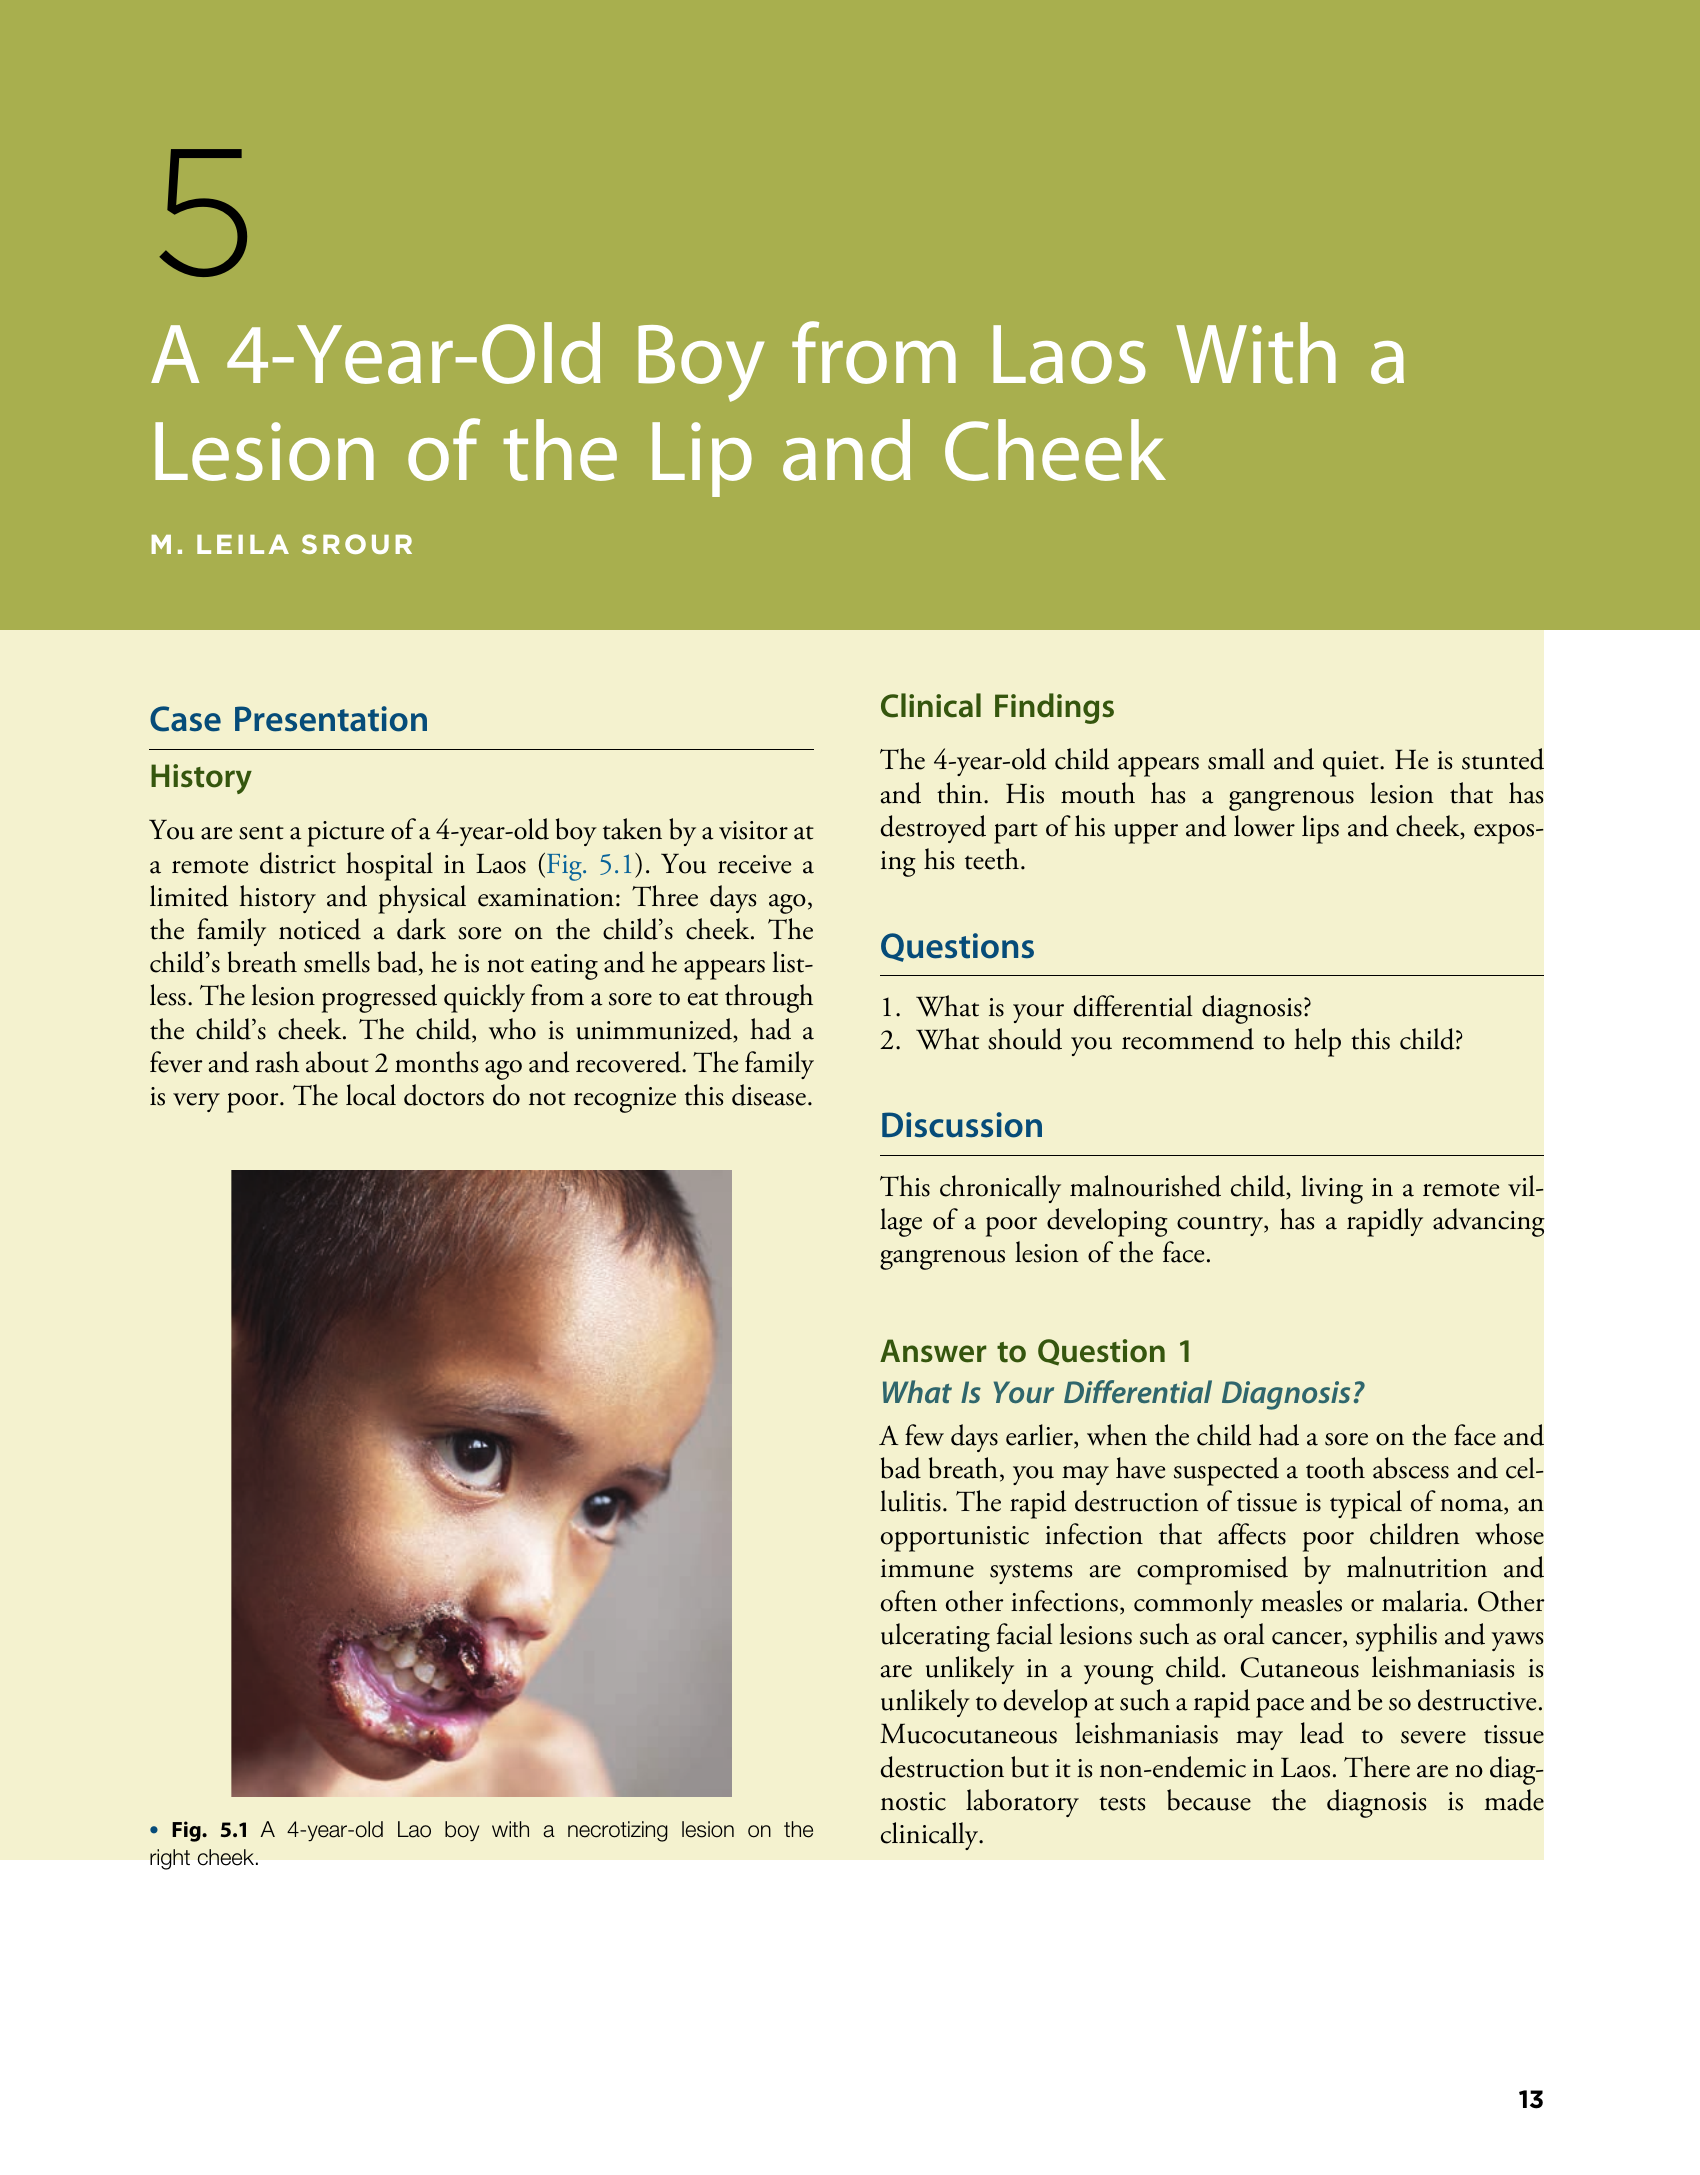

[Case 82] 82 A 31 Year Old Man from Guatemala With Acute 2022 Clinical Cases in Tro


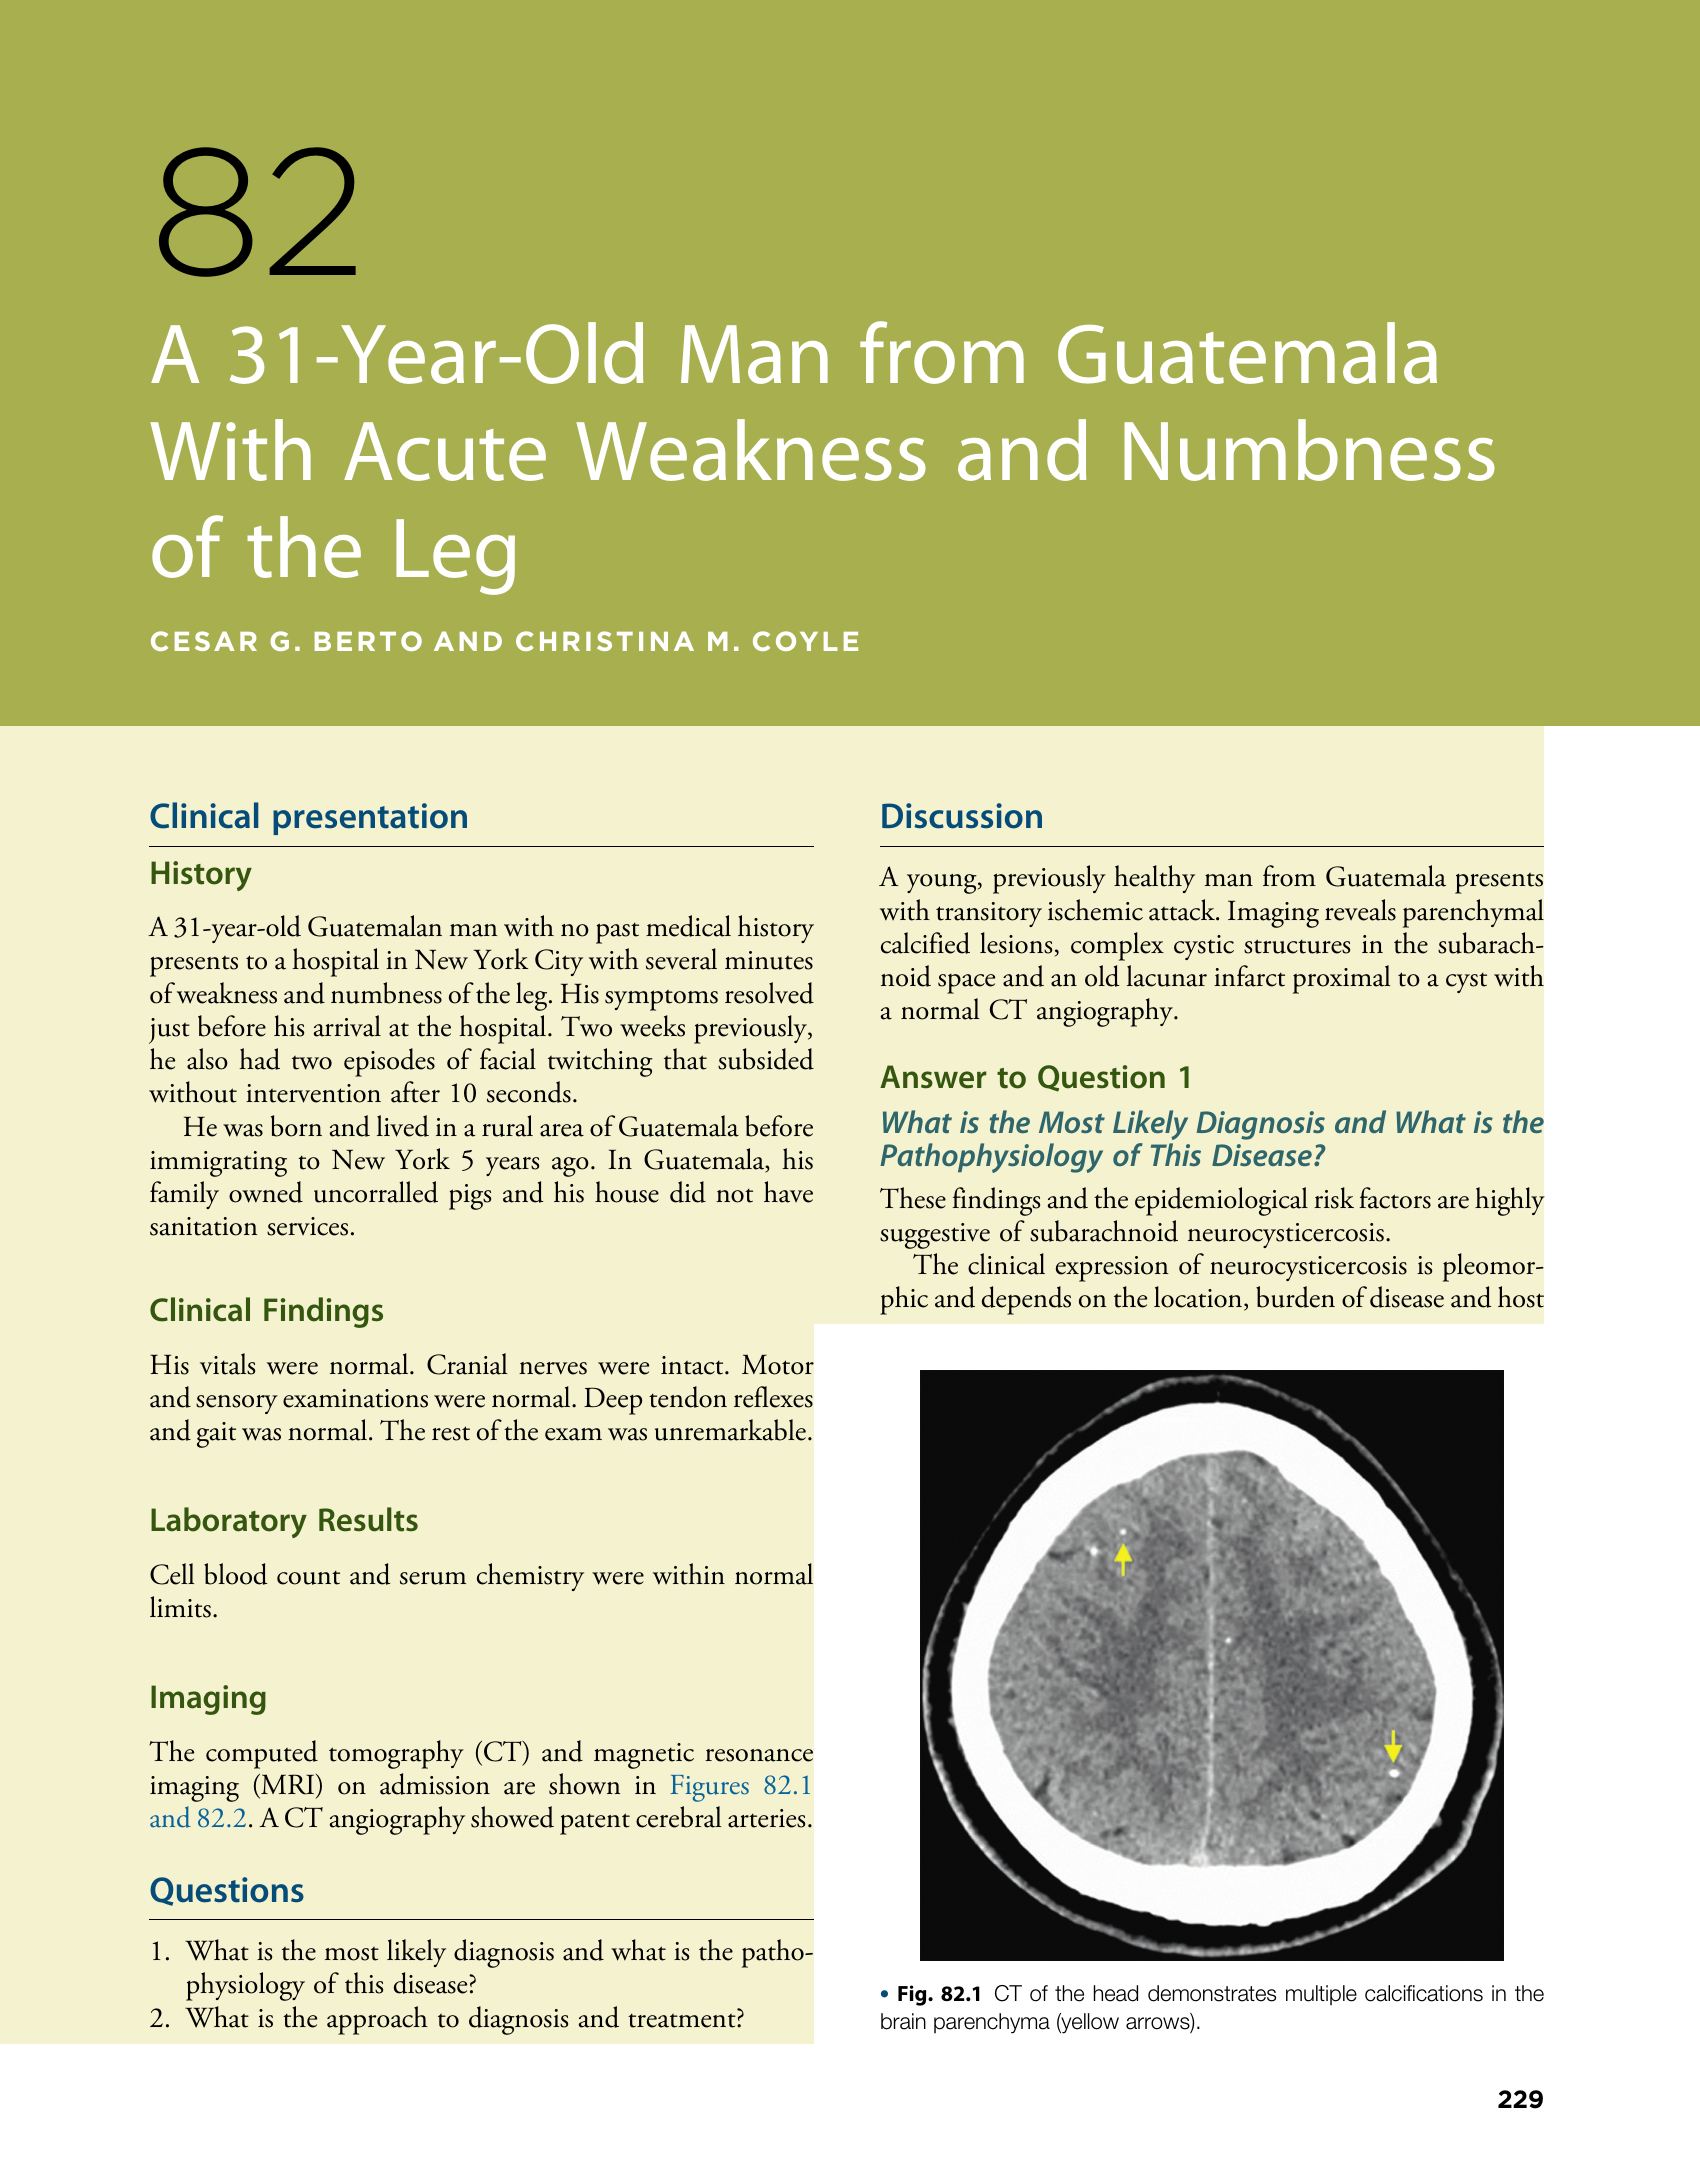

[Case 19] 19 A 40 Year Old Man from Togo With Subcutaneou 2022 Clinical Cases in Tro


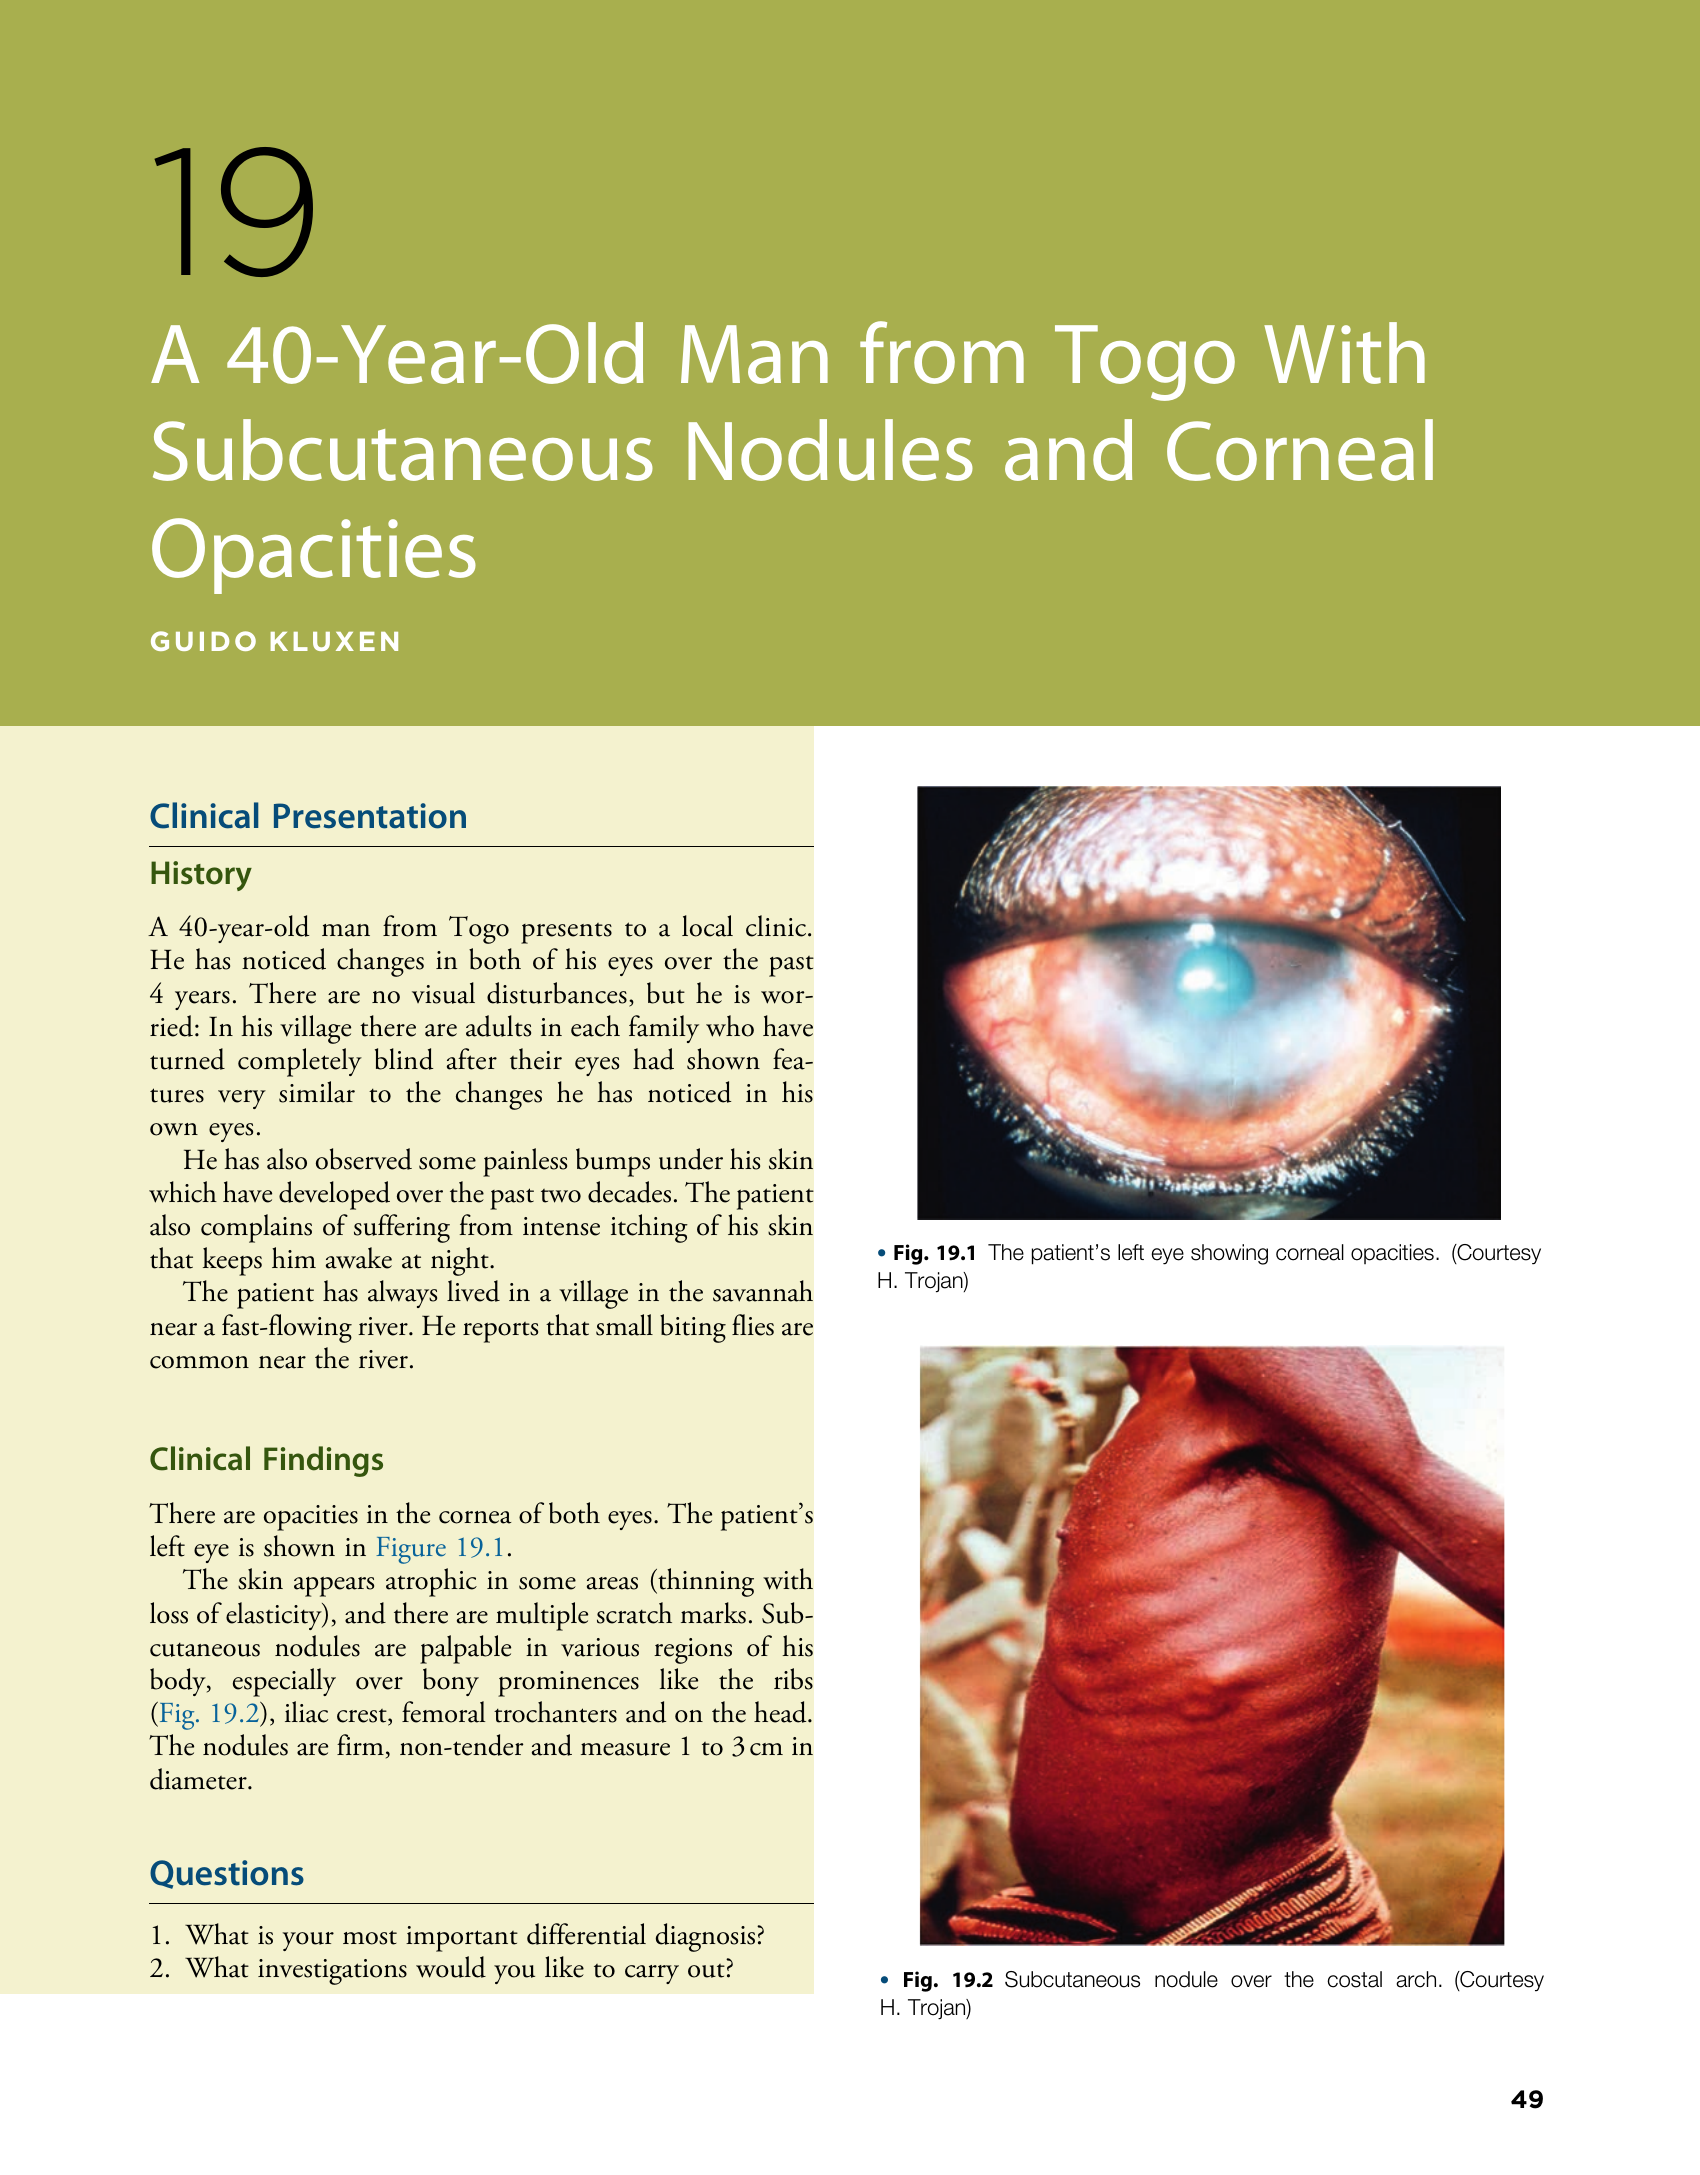

In [16]:
from PIL import Image
from IPython.display import display

def show_first_pages(hits, top=5):
    for h in hits[:top]:
        p = h.payload or {}
        paths = p.get("page_paths") or []
        if not paths:
            continue
        try:
            print(f"[Case {p.get('case_id')}] {p.get('case_title')}")
            display(Image.open(paths[0]))
        except Exception as e:
            print("Cannot open:", paths[0], "->", e)

show_first_pages(hits, top=3)


In [18]:

candidates = [1, 44]

def search_cases_MAX_restrict(question: str, candidate_case_ids, k=5, m_query=16, per_subvec_limit=40, hnsw_ef=256):
    subvecs = encode_query_topk(question, top_m=m_query)
    params = models.SearchParams(hnsw_ef=hnsw_ef)

    qfilter = models.Filter(should=[
        models.FieldCondition(key="case_id", match=models.MatchValue(value=int(cid)))
        for cid in candidate_case_ids
    ])

    agg = {}
    for v in subvecs:
        hits = client.search(
            collection_name=COLLECTION_CASES,
            query_vector=v,
            limit=per_subvec_limit,
            with_payload=True,
            query_filter=qfilter,
            search_params=params
        )
        for h in hits:
            pid, sc, pl = h.id, h.score, h.payload
            if pid not in agg or sc > agg[pid][0]:
                agg[pid] = (sc, pl)

    ranked = sorted(agg.items(), key=lambda kv: kv[1][0], reverse=True)[:k]
    return [type("Hit", (), {"id": i, "score": sc, "payload": pl}) for i,(sc,pl) in ranked]

question = "Ebola viral hemorrhagic fever with bleeding and shock; nursing isolation and PPE precautions; patient from Sudan."
hits = search_cases_MAX_restrict(question, candidates, k=5, m_query=12, per_subvec_limit=50, hnsw_ef=256)
for i, h in enumerate(hits, 1):
    p = h.payload or {}
    print(f"Rank {i} | score={h.score:.3f} | case_id={p.get('case_id')} | {p.get('case_title')}")


/tmp/ipython-input-3072108952.py:14: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(


Rank 1 | score=0.307 | case_id=1 | 1 A 20 Year Old Woman from Sudan With Fever 2022 Clinical Cases in Tropi
Rank 2 | score=0.258 | case_id=44 | 44 A 7 Year Old Girl from South Sudan With 2022 Clinical Cases in Tropica


# Retrival with page-level and then combine with case level for getting case

## config

In [19]:


# Suggested default parameters (tune as needed)
DEFAULTS = dict(
    page_m_query=12,               # #sub-vectors from ColPali for page-level
    page_per_subvec_limit=120,     # breadth per sub-vector at page-level
    page_hnsw_ef=512,              # higher → better recall (slower)
    case_m_query=12,               # #sub-vectors from ColPali for case-level
    case_per_subvec_limit=80,      # breadth per sub-vector at case-level
    case_hnsw_ef=512,              # higher → better recall (slower)
    candidate_cases=120,           # how many candidate cases from page hits
    top_pages_show=12,             # how many top evidence pages to print
    top_cases_show=5,              # final top-k cases
    pages_per_case_for_context=2,  # #evidence pages per case to OCR for LLM
    max_context_chars=4000         # char budget for LLM context (roughly ~600–900 tokens)
)


# Optional sanity checks
try:
    info_pages = client.get_collection(COLLECTION_PAGES)
    info_cases = client.get_collection(COLLECTION_CASES)
    print("[ok] Qdrant connected")
    print("[ok] pages:", info_pages.status, "| cases:", info_cases.status)
except Exception as e:
    print("[warn]", e)


[ok] Qdrant connected
[ok] pages: green | cases: green


## Helpers (encoder + pretty printers)

In [20]:


def encode_query_topk(q: str, top_m: int = 12):
    """Encode a query with ColPali into a multi-vector and keep top_m sub-vectors to reduce noise and latency."""
    subvecs = embed_queries(model, processor, device, [q])[0]
    return subvecs[:top_m]

def print_page_hits(hits, title=None, limit=None):
    """Pretty-print page-level hits."""
    if title: print(title)
    for i, h in enumerate(hits[:(limit or len(hits))], 1):
        p = h.payload or {}
        print(f"Rank {i:>2} | score={h.score:.3f} | case_id={p.get('case_id')} | page={p.get('page_number')} | {p.get('path')}")

def print_case_hits(hits, title=None):
    """Pretty-print case-level hits."""
    if title: print(title)
    for i, h in enumerate(hits, 1):
        p = h.payload or {}
        print(f"Rank {i:>2} | score={h.score:.3f} | case_id={p.get('case_id')} | {p.get('case_title')}")


## Page-level retrieval (MAX fusion over multivectors)

In [22]:
def search_pages_MAX(
    question: str,
    k_pages: int = 100,
    m_query: int = DEFAULTS["page_m_query"],
    per_subvec_limit: int = DEFAULTS["page_per_subvec_limit"],
    hnsw_ef: int = DEFAULTS["page_hnsw_ef"]
):
    """
    Page-level retrieval with ColPali multivectors on a MAX-SIM collection.
    We query each sub-vector separately, take top-N page hits per sub-vector, and
    aggregate with MAX score per page (mimicking MAX comparator behavior).
    """
    subvecs = encode_query_topk(question, top_m=m_query)
    try:
        params = models.SearchParams(hnsw_ef=hnsw_ef)  # may be ignored by older clients
    except Exception:
        params = None

    agg = {}  # page_point_id -> (max_score, payload)
    for v in subvecs:
        hits = client.search(  # deprecated warning is fine; your client still supports it
            collection_name=COLLECTION_PAGES,
            query_vector=v,    # unnamed vector for unnamed multivector collections
            limit=per_subvec_limit,
            with_payload=True,
            search_params=params
        )
        for h in hits:
            pid, sc, pl = h.id, h.score, h.payload
            if pid not in agg or sc > agg[pid][0]:
                agg[pid] = (sc, pl)

    ranked = sorted(agg.items(), key=lambda kv: kv[1][0], reverse=True)[:k_pages]
    return [type("Hit", (), {"id": pid, "score": sc, "payload": pl}) for pid,(sc,pl) in ranked]


## Aggregate pages → cases (PAGE→CASE) + (optional) Fusion

In [23]:
def pages_to_case_candidates(hits_pages, top_cases=DEFAULTS["candidate_cases"]):
    """
    From page hits, compute candidate cases by taking the best page score per case,
    then keep top-N cases as candidates for a second-stage (optional) case-level search.
    """
    case_best = {}
    for h in hits_pages:
        p = h.payload or {}
        cid = p.get("case_id")
        if cid is None:
            continue
        ttl = p.get("case_title", "")
        if cid not in case_best or h.score > case_best[cid][0]:
            case_best[cid] = (h.score, ttl)
    ranked = sorted(case_best.items(), key=lambda kv: kv[1][0], reverse=True)[:top_cases]
    return [int(cid) for cid, _ in ranked]

def rank_cases_from_pages(hits_pages, top_k=DEFAULTS["top_cases_show"]):
    """
    Pure PAGE→CASE ranking: score(case) = max_page_score(case).
    This preserves page evidence—recommended for clinical QA with citations.
    """
    case_best = {}
    for h in hits_pages:
        p = h.payload or {}
        cid = int(p["case_id"])
        ttl = p.get("case_title", "")
        if cid not in case_best or h.score > case_best[cid][0]:
            case_best[cid] = (h.score, ttl)
    ranked = sorted(case_best.items(), key=lambda kv: kv[1][0], reverse=True)[:top_k]
    return [type("Hit", (), {"id": cid, "score": sc, "payload": {"case_id": cid, "case_title": ttl}})
            for cid,(sc,ttl) in ranked]

def search_cases_MAX_with_candidates(
    question: str,
    candidate_case_ids: list[int],
    k: int = DEFAULTS["top_cases_show"],
    m_query: int = DEFAULTS["case_m_query"],
    per_subvec_limit: int = DEFAULTS["case_per_subvec_limit"],
    hnsw_ef: int = DEFAULTS["case_hnsw_ef"]
):
    """
    Optional second-stage case-level re-ranking within candidate cases using MAX fusion.
    Useful if you want a hybrid score (page + case).
    """
    if not candidate_case_ids:
        return []
    subvecs = encode_query_topk(question, top_m=m_query)
    try:
        params = models.SearchParams(hnsw_ef=hnsw_ef)
    except Exception:
        params = None

    qfilter = models.Filter(should=[
        models.FieldCondition(key="case_id", match=models.MatchValue(value=int(cid)))
        for cid in candidate_case_ids
    ])

    agg = {}  # case_point_id -> (max_score, payload)
    for v in subvecs:
        hits = client.search(
            collection_name=COLLECTION_CASES,
            query_vector=v,
            limit=per_subvec_limit,
            with_payload=True,
            query_filter=qfilter,
            search_params=params
        )
        for h in hits:
            pid, sc, pl = h.id, h.score, h.payload
            if pid not in agg or sc > agg[pid][0]:
                agg[pid] = (sc, pl)

    ranked = sorted(agg.items(), key=lambda kv: kv[1][0], reverse=True)[:k]
    return [type("Hit", (), {"id": i, "score": sc, "payload": pl}) for i,(sc,pl) in ranked]

def fuse_cases(page_hits, case_hits, w_page=0.75, w_case=0.25, top_k=DEFAULTS["top_cases_show"]):
    """
    Hybrid fusion: final_score = w_page * max_page_score + w_case * case_level_score.
    Keeps page evidence while stabilizing with case-level signal.
    """
    page_best = {}
    for h in page_hits:
        p = h.payload or {}
        cid = int(p["case_id"])
        ttl = p.get("case_title","")
        if cid not in page_best or h.score > page_best[cid][0]:
            page_best[cid] = (h.score, ttl)

    case_best = {}
    for h in case_hits:
        p = h.payload or {}
        cid = int(p["case_id"])
        ttl = p.get("case_title","")
        if cid not in case_best or h.score > case_best[cid][0]:
            case_best[cid] = (h.score, ttl)

    all_ids = set(page_best) | set(case_best)
    fused = []
    for cid in all_ids:
        ps = page_best.get(cid, (0.0, ""))[0]
        cs = case_best.get(cid, (0.0, ""))[0]
        ttl = (page_best.get(cid) or case_best.get(cid) or (0.0, ""))[1]
        fused.append((cid, w_page*ps + w_case*cs, ttl))

    fused.sort(key=lambda x: x[1], reverse=True)
    return [type("Hit", (), {"id": cid, "score": sc, "payload": {"case_id": cid, "case_title": ttl}})
            for cid,sc,ttl in fused[:top_k]]


## Get best evidence pages per case (for OCR/LLM)

In [24]:
def search_pages_in_case(
    question: str,
    case_id: int,
    top_pages: int = 3,
    m_query: int = DEFAULTS["page_m_query"],
    per_subvec_limit: int = DEFAULTS["page_per_subvec_limit"],
    hnsw_ef: int = DEFAULTS["page_hnsw_ef"]
):
    """
    Retrieve the best evidence pages within a specific case_id.
    Useful to assemble citations and OCR text for the LLM.
    """
    subvecs = encode_query_topk(question, top_m=m_query)
    try:
        params = models.SearchParams(hnsw_ef=hnsw_ef)
    except Exception:
        params = None

    qfilter = models.Filter(must=[
        models.FieldCondition(key="case_id", match=models.MatchValue(value=int(case_id)))
    ])

    agg = {}  # page_point_id -> (max_score, payload)
    for v in subvecs:
        hits = client.search(
            collection_name=COLLECTION_PAGES,
            query_vector=v,
            limit=per_subvec_limit,
            with_payload=True,
            query_filter=qfilter,
            search_params=params
        )
        for h in hits:
            pid, sc, pl = h.id, h.score, h.payload
            if pid not in agg or sc > agg[pid][0]:
                agg[pid] = (sc, pl)

    ranked = sorted(agg.items(), key=lambda kv: kv[1][0], reverse=True)[:top_pages]

    # Normalize payload for OCR convenience
    out = []
    for pid,(sc,pl) in ranked:
        out.append({
            "id": pid,
            "score": float(sc),
            "case_id": int(pl.get("case_id")),
            "case_title": pl.get("case_title",""),
            "page_number": pl.get("page_number"),
            "path": pl.get("path") or (pl.get("page_paths") or [None])[0]
        })
    return out


## OCR & build context text for the LLM

In [25]:
import re
from PIL import Image
import pytesseract

def clean_text(s: str) -> str:
    """Basic cleanup for OCR output: de-hyphen, collapse whitespace, normalize line breaks."""
    s = re.sub(r'-\n', '', s)
    s = re.sub(r'[ \t]+\n', '\n', s)
    s = re.sub(r'\n{2,}', '\n\n', s)
    return s.strip()

def ocr_image_page(path: str, lang="eng") -> str:
    """OCR a page image (PNG/JPG) and return cleaned text."""
    img = Image.open(path)
    txt = pytesseract.image_to_string(img, lang=lang)
    return clean_text(txt)

def build_context_from_pages(pages: list[dict], max_chars: int = DEFAULTS["max_context_chars"]) -> tuple[str, list[dict]]:
    """
    Build a compact textual CONTEXT for the LLM:
    - pages: list of dicts with {case_id, case_title, page_number, path, score}
    - returns (context_text, contexts_meta_for_logging)
    """
    ctx_blocks, meta = [], []
    total = 0
    for p in pages:
        text = ocr_image_page(p["path"])
        if not text:
            continue
        header = f"[Case {p['case_id']} | {p.get('case_title','')} | page {p['page_number']} | score {p['score']:.3f}]"
        block = f"{header}\n{text}"
        if total + len(block) > max_chars:
            break
        ctx_blocks.append(block)
        meta.append({
            "case_id": p["case_id"], "case_title": p.get("case_title",""),
            "page_number": p["page_number"], "path": p["path"], "score": p["score"],
            "snippet": text[:300]
        })
        total += len(block)
    return "\n\n".join(ctx_blocks), meta


## End-to-End helper (query → pages → cases → context)

In [30]:
def retrieve_e2e(
    question: str,
    pages_per_case_for_context: int = DEFAULTS["pages_per_case_for_context"],
    use_fusion: bool = False,   # False: PAGE→CASE only; True: Fusion (PAGE+CASE)
    show_intermediate: bool = True
):
    # Stage-1: page-level (broad)
    page_hits = search_pages_MAX(
        question,
        k_pages=max(DEFAULTS["top_pages_show"], DEFAULTS["candidate_cases"]),
        m_query=DEFAULTS["page_m_query"],
        per_subvec_limit=DEFAULTS["page_per_subvec_limit"],
        hnsw_ef=DEFAULTS["page_hnsw_ef"]
    )
    if show_intermediate:
        print_page_hits(page_hits, title="\n=== Top pages (evidence) ===", limit=DEFAULTS["top_pages_show"])

    # Collect candidate case_ids from best page scores
    candidates = pages_to_case_candidates(page_hits, top_cases=DEFAULTS["candidate_cases"])
    if show_intermediate:
        print("\nCandidates (first 20):", candidates[:20])

    # Stage-2: case-level re-ranking (optional)
    if use_fusion:
        # Wide case-level search within candidates, then fuse with page scores
        case_hits_wide = search_cases_MAX_with_candidates(
            question,
            candidate_case_ids=candidates,
            k=DEFAULTS["candidate_cases"],
            m_query=DEFAULTS["case_m_query"],
            per_subvec_limit=DEFAULTS["case_per_subvec_limit"],
            hnsw_ef=DEFAULTS["case_hnsw_ef"]
        )
        final_cases = fuse_cases(page_hits, case_hits_wide, w_page=0.75, w_case=0.25, top_k=DEFAULTS["top_cases_show"])
    else:
        # Pure PAGE→CASE ranking (recommended for strong page evidence)
        final_cases = rank_cases_from_pages(page_hits, top_k=DEFAULTS["top_cases_show"])

    print_case_hits(final_cases, title="\n=== Final case hits ===")

    # Fetch best pages per final case (to feed OCR/LLM and show citations)
    pages_by_case = {}
    for h in final_cases:
        p = h.payload or {}
        cid = int(p["case_id"])
        pages = search_pages_in_case(
            question, case_id=cid,
            top_pages=pages_per_case_for_context,
            m_query=DEFAULTS["page_m_query"],
            per_subvec_limit=DEFAULTS["page_per_subvec_limit"],
            hnsw_ef=DEFAULTS["page_hnsw_ef"]
        )
        pages_by_case[cid] = pages
        print(f"\n--- Best pages for case_id={cid} ---")
        for j, pg in enumerate(pages, 1):
            print(f"  p{j} | score={pg['score']:.3f} | {pg['path']}")

    # Build the LLM context from the selected pages (ordered by final cases)
    ranked_pages_for_ctx = []
    for h in final_cases:
        cid = int((h.payload or {}).get("case_id"))
        ranked_pages_for_ctx.extend(pages_by_case.get(cid, []))

    context_text, contexts_meta = build_context_from_pages(
        ranked_pages_for_ctx, max_chars=DEFAULTS["max_context_chars"]
    )
    print(f"\n[context chars] {len(context_text)}")

    return dict(
        page_hits=page_hits,
        final_cases=final_cases,
        pages_by_case=pages_by_case,
        context_text=context_text,
        contexts_meta=contexts_meta
    )


## Example query (Ebola)

In [31]:
question = (
  "Ebola virus disease: hemorrhagic fever with bleeding and shock; "
  "nursing isolation, PPE and contact precautions; patient from Sudan."
)

result = retrieve_e2e(
    question,
    pages_per_case_for_context=DEFAULTS["pages_per_case_for_context"],
    use_fusion=False,   # set True to combine PAGE and CASE signals
    show_intermediate=True
)




/tmp/ipython-input-3348236797.py:21: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(  # deprecated warning is fine; your client still supports it



=== Top pages (evidence) ===
Rank  1 | score=0.371 | case_id=60 | page=2 | /content/drive/MyDrive/Project-AI/PDF-Data/60---A-6-Year-Old-Boy-from-Malawi-With-Proptos_2022_Clinical-Cases-in-Tropic_page_2.png
Rank  2 | score=0.369 | case_id=84 | page=2 | /content/drive/MyDrive/Project-AI/PDF-Data/84---A-64-Year-Old-Japanese-Man-With-Generalize_2022_Clinical-Cases-in-Tropi_page_2.png
Rank  3 | score=0.363 | case_id=76 | page=2 | /content/drive/MyDrive/Project-AI/PDF-Data/76---A-55-Year-Old-Woman-from-Turkey-With-Feve_2022_Clinical-Cases-in-Tropic_page_2.png
Rank  4 | score=0.358 | case_id=2 | page=2 | /content/drive/MyDrive/Project-AI/PDF-Data/2---A-7-Year-Old-Girl-from-Peru-With-a-Chron_2022_Clinical-Cases-in-Tropical_page_2.png
Rank  5 | score=0.349 | case_id=55 | page=2 | /content/drive/MyDrive/Project-AI/PDF-Data/55---A-40-Year-Old-Male-Farmer-from-Peru-With-Ch_2022_Clinical-Cases-in-Trop_page_2.png
Rank  6 | score=0.342 | case_id=11 | page=3 | /content/drive/MyDrive/Project-AI/PDF-Da

/tmp/ipython-input-1356378198.py:25: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(



--- Best pages for case_id=60 ---
  p1 | score=0.371 | /content/drive/MyDrive/Project-AI/PDF-Data/60---A-6-Year-Old-Boy-from-Malawi-With-Proptos_2022_Clinical-Cases-in-Tropic_page_2.png
  p2 | score=0.218 | /content/drive/MyDrive/Project-AI/PDF-Data/60---A-6-Year-Old-Boy-from-Malawi-With-Proptos_2022_Clinical-Cases-in-Tropic_page_1.png

--- Best pages for case_id=84 ---
  p1 | score=0.369 | /content/drive/MyDrive/Project-AI/PDF-Data/84---A-64-Year-Old-Japanese-Man-With-Generalize_2022_Clinical-Cases-in-Tropi_page_2.png
  p2 | score=0.294 | /content/drive/MyDrive/Project-AI/PDF-Data/84---A-64-Year-Old-Japanese-Man-With-Generalize_2022_Clinical-Cases-in-Tropi_page_3.png

--- Best pages for case_id=76 ---
  p1 | score=0.363 | /content/drive/MyDrive/Project-AI/PDF-Data/76---A-55-Year-Old-Woman-from-Turkey-With-Feve_2022_Clinical-Cases-in-Tropic_page_2.png
  p2 | score=0.262 | /content/drive/MyDrive/Project-AI/PDF-Data/76---A-55-Year-Old-Woman-from-Turkey-With-Feve_2022_Clinical-Cases-in-T